In [1]:
# Requirements
# --------------------------------------
# conda install -c anaconda numpy
# conda install -c anaconda seaborn
# conda install -c anaconda pandas
# conda install -c conda-forge matplotlib
# conda install -c conda-forge pydotplus
# conda install -c anaconda scikit-learn
# conda install -c anaconda six
#----------------------------------------
# End

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
%matplotlib inline

In [3]:
# Load The Given Data
train=pd.read_csv('dataset/kaggle/titanic/train.csv')
test=pd.read_csv('dataset/kaggle/titanic/test.csv')
gender = pd.read_csv('dataset/kaggle/titanic/gender_submission.csv')

In [4]:
# Checking Head e.g: first few rows of the train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Checking Head e.g: first few rows of the test dataset
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


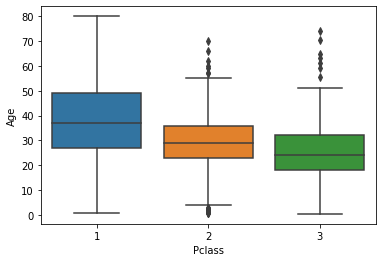

In [6]:
sns.boxplot(x='Pclass', y='Age', data=train)
# Class 1 passenger (Avg age=37 approx) is older other passenger classes

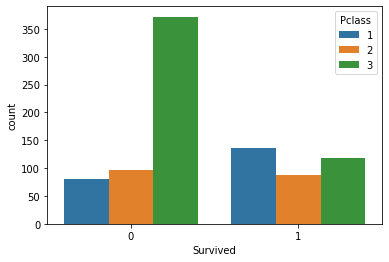

In [7]:
# Let's Analyze the Survived Column based on Passenger Class type
sns.countplot(x='Survived',hue='Pclass',data=train)
#So most of the most of the class 3 not survivied 

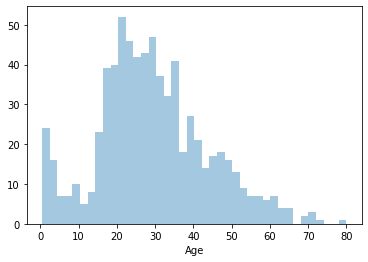

In [8]:
sns.distplot(train['Age'].dropna(),kde=False,bins=40)
# The Distribution plott on the Age data

In [9]:
train.info()
# Let's check all not null data and number of rows in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


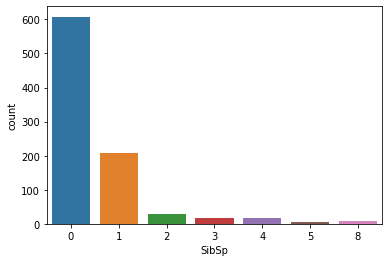

In [10]:
# Checking SibSp type passenger
sns.countplot(x='SibSp', data=train)
# Analogy Says most of the passengers were type e.g: 0
# This will not help to solve our problem

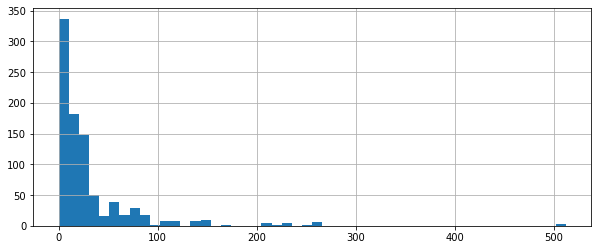

In [11]:
train['Fare'].hist(bins=50,figsize=(10,4))

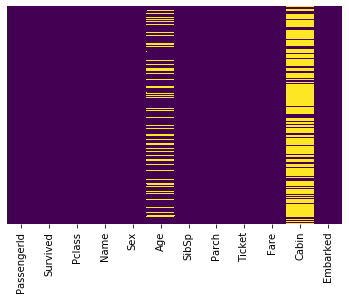

In [12]:
# well, Is threre any missing data in any column?
sns.heatmap(train.isnull(), yticklabels=False,cbar=False,cmap='viridis')
# Yes, we have two columns that has missing values
# Expecting that the test dataset has the same issue

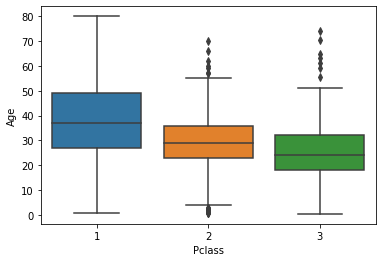

In [13]:
# How to solve missing value problem?
# Let's start from the Age column
# I have found a relation on Age and Pclass.
# We can fill the NaN filed of the Age column using the average age of the corresponding class
# Box Plotting can help us
sns.boxplot(x='Pclass', y='Age', data=train)

In [14]:
# Based on the previous analogy we can fill the null values
#In Age column aith the average value of ages considering their Pclass data
def fill_age(cols):
    Age=cols[0]
    Pclass=cols[1]
    
    if pd.isnull(Age):
        
        if Pclass==1:
            return 37
        elif Pclass==3:
            return 29
        else:
            return 24
    else:
        return Age

In [15]:
# Apply this filter to the Age Column
train['Age'] = train[['Age','Pclass']].apply(fill_age,axis=1)

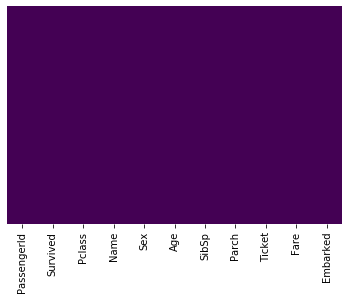

In [16]:
# Well, we can see from the first heatmap that there are lot's of NaN in Cabin column
# Since it is not mandatory for this survival type problem, we can drop this column
train.drop('Cabin',axis=1,inplace=True)
sns.heatmap(train.isnull(), yticklabels=False,cbar=False,cmap='viridis')
# Longer Missing Values, right?

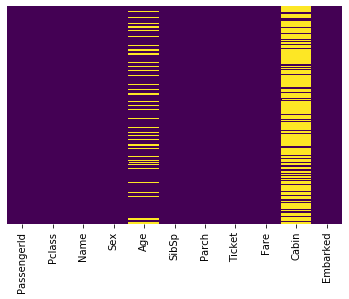

In [17]:
# Let's check out the test dataset
sns.heatmap(test.isnull(), yticklabels=False,cbar=False,cmap='viridis')

In [18]:
# we can apply the same logic like train dataset
test.drop('Cabin',axis=1,inplace=True)
test['Age'] = test[['Age','Pclass']].apply(fill_age,axis=1)

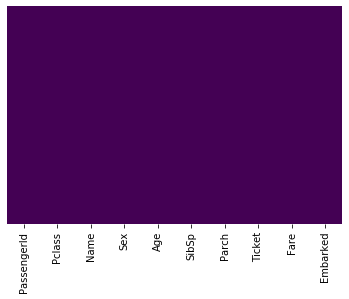

In [19]:
sns.heatmap(test.isnull(), yticklabels=False,cbar=False,cmap='viridis')
# Longer Missing Values in test Data

In [20]:
# Let's Wrok with the categorical type data
# Since logistic Regression need only numerical type data to feed into the train set,
# we need to process the categorical data (String Type data)
# Sex and Embarked column has 0 and 1 type data... this means less column, we can convert them as a categorical data
sex=pd.get_dummies(train['Sex'],drop_first=True)
embark=pd.get_dummies(train['Embarked'],drop_first=True)


In [21]:
train=pd.concat([train,sex,embark],axis=1)

In [22]:
# Drop all String type column, they are useless now. We have sex and Embarked data as categorical
# Other columns no need to feed into our Machine Learning Algorithm
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [23]:
# Same logic can be applied to the test dataset
test_sex=pd.get_dummies(test['Sex'],drop_first=True)
test_embark=pd.get_dummies(test['Embarked'],drop_first=True)

In [24]:
test=pd.concat([test,test_sex,test_embark],axis=1)
test.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [25]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [26]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,1
2,894,2,62.0,0,0,9.6875,1,1,0
3,895,3,27.0,0,0,8.6625,1,0,1
4,896,3,22.0,1,1,12.2875,0,0,1


In [27]:
# Let's Split our processed dataset for training
X=train.drop('Survived',axis=1)
y=train['Survived']

In [28]:
logmodel=LogisticRegression(solver='lbfgs',tol=0.001,max_iter=1000) # Logistic Regression Model
dtree = DecisionTreeClassifier() # Decision Tree Model

In [29]:
# Fit Training Data to our classifiers
logmodel.fit(X,y)
dtree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
# In both test.csv and gender_submission.csv, there is a unique column which is PassengerId
# I am taking the rows where the PassengerId also exists in gender_submission.csv's passengerId 
# In this case, I can evalute the accuracy from gender dataset after predicting it with determined test dataset 
my_x_test=test.loc[test['PassengerId'].isin(gender['PassengerId'])]

In [31]:
# For measuring the accuracy of our model
my_y_test=gender['Survived']

In [32]:
# Predition Using the two models
test_prediction=logmodel.predict(my_x_test.fillna(test.mean()))
dtree_prediction=dtree.predict(my_x_test.fillna(test.mean()))

In [33]:
print(classification_report(my_y_test,test_prediction)) # Accuracy of Logistic Regression model

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       266
           1       0.89      0.93      0.91       152

    accuracy                           0.93       418
   macro avg       0.93      0.93      0.93       418
weighted avg       0.93      0.93      0.93       418



In [34]:
print(classification_report(my_y_test,dtree_prediction)) # Accuracy of Decision Tree model

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       266
           1       0.62      0.69      0.65       152

    accuracy                           0.73       418
   macro avg       0.72      0.73      0.72       418
weighted avg       0.74      0.73      0.74       418



In [35]:
result = my_x_test
result['Logistic Prediction']=test_prediction
result['Decision Tree Prediction']=dtree_prediction
result['Actual Survival'] = my_y_test

In [36]:
result

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Logistic Prediction,Decision Tree Prediction,Actual Survival
0,892,3,34.5,0,0,7.8292,1,1,0,0,0,0
1,893,3,47.0,1,0,7.0000,0,0,1,0,0,1
2,894,2,62.0,0,0,9.6875,1,1,0,0,0,0
3,895,3,27.0,0,0,8.6625,1,0,1,0,0,0
4,896,3,22.0,1,1,12.2875,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,29.0,0,0,8.0500,1,0,1,0,0,0
414,1306,1,39.0,0,0,108.9000,0,0,0,1,1,1
415,1307,3,38.5,0,0,7.2500,1,0,1,0,0,0
416,1308,3,29.0,0,0,8.0500,1,0,1,0,0,0


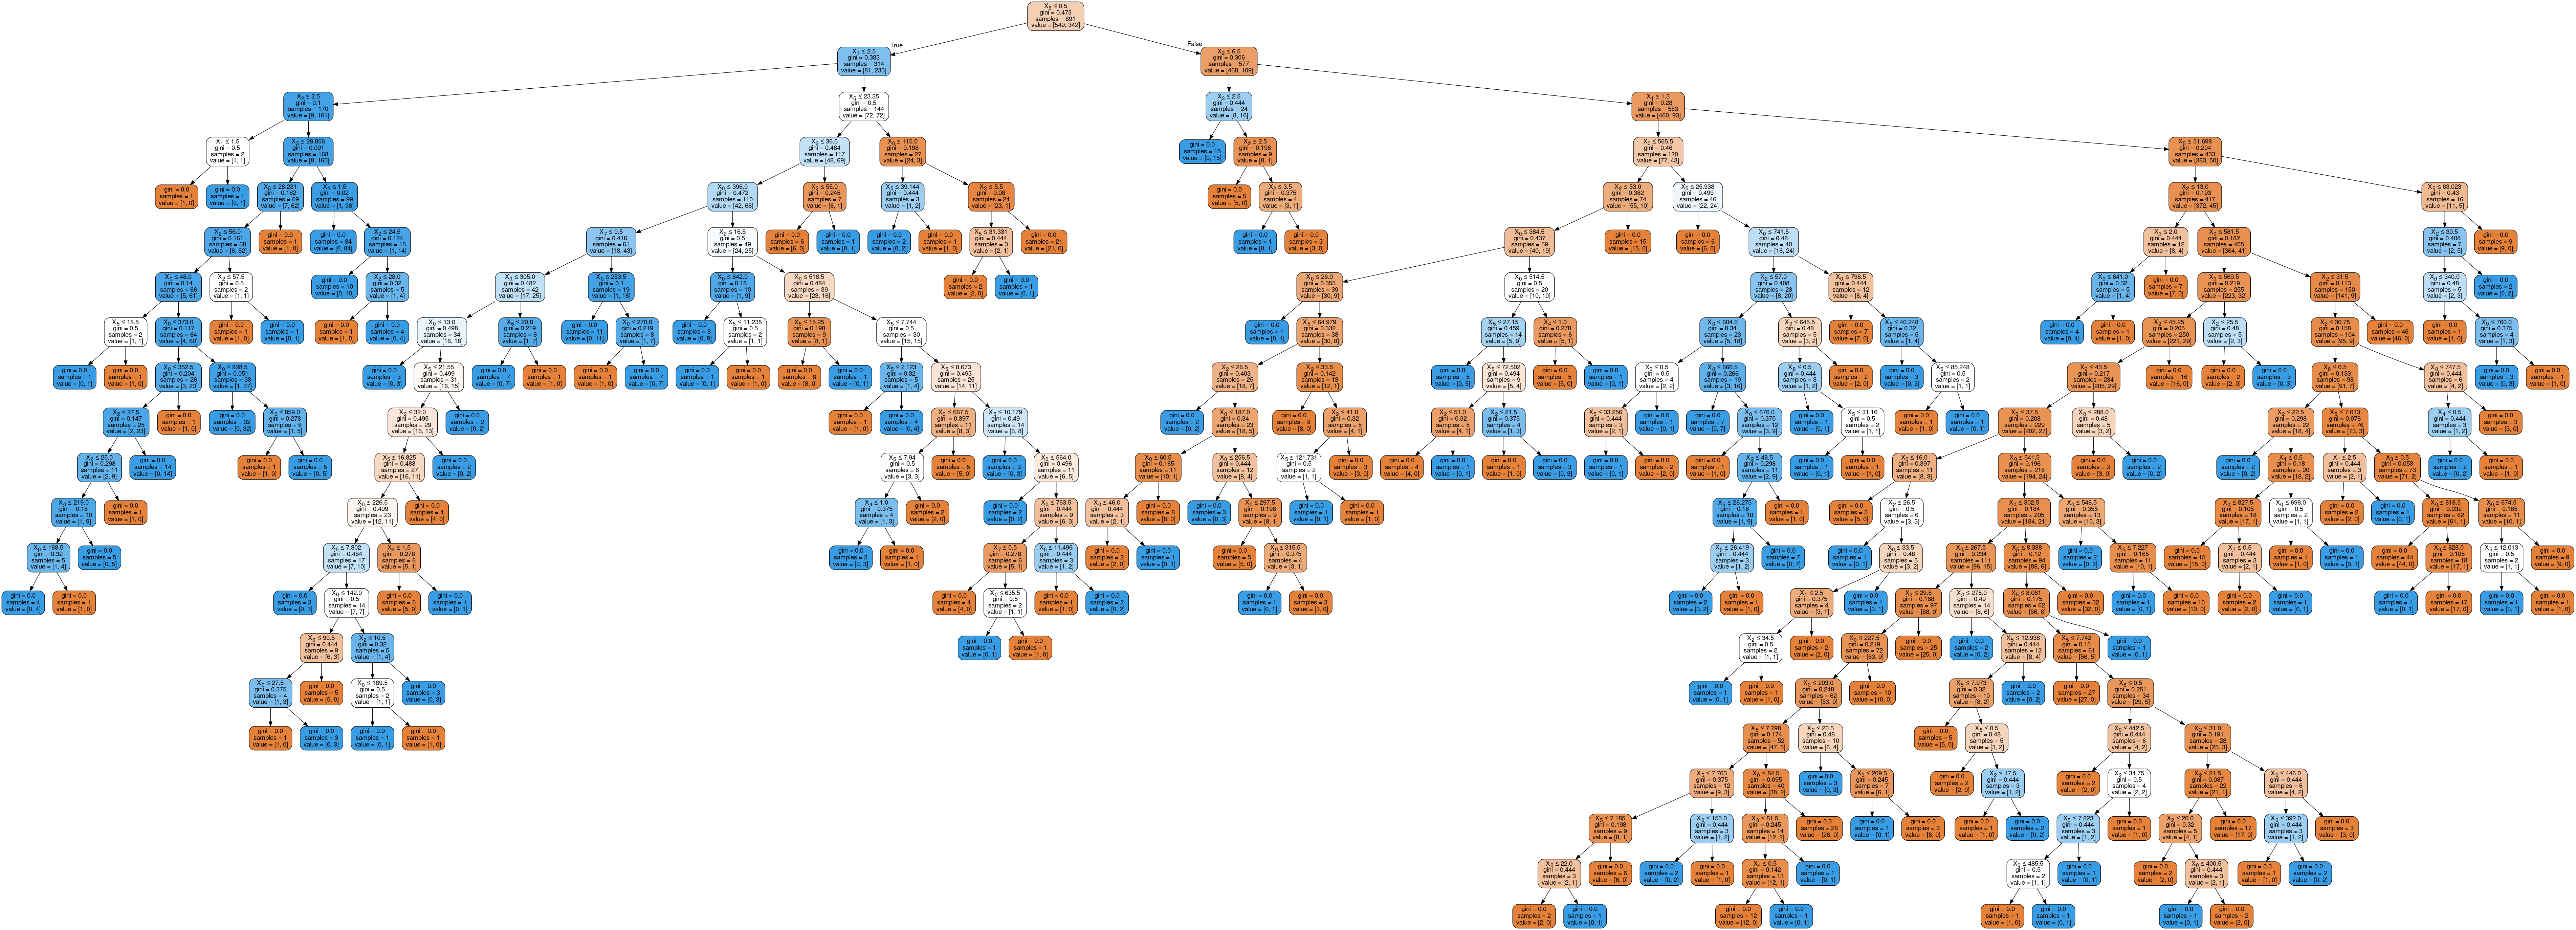

In [39]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())